# Assignment 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

1. 
Attempt to compare different clustering algorithms based on how they cluster, as well as time.
- K-means
- Spectral clustering
- Mini-Batch K-means
- Gaussian mixture
- DBSCAN - although I did not teach you, it is simply a density-based that treats nearby instance as neighbors. It has
two parameters (eps, min-points) that define the distance to considered as neighbors.

Attempt to play around with different parameters of each model.
Last but probably the most important, interpret the result (why
this algorithm works well or otherwise)

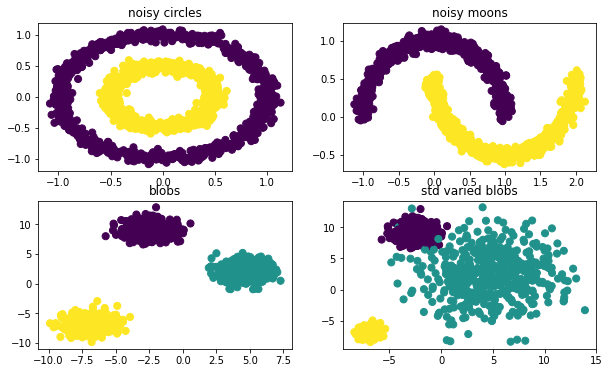

In [2]:
def plot_clusters(ax, datasets, title):
    X, y = datasets
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
    ax.set_title(title)

n_samples = 1500
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

#noisy_circles
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
#noisy_moons
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

#normal blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=42)

#std varied blobs
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 3.5, 0.5],
                            random_state=42)

datasets = [noisy_circles, noisy_moons, blobs, varied]
title = ['noisy circles', 'noisy moons', 
         'blobs', 'std varied blobs']
for i, axi in enumerate(ax.flat):
    plot_clusters(axi, datasets[i], title[i])

In [3]:
# Your code here

2. Implement K-means from scratch. Should be pretty simple

    1. Randomly choose n clusters from X
    2. Assign lables based on closest center
    3. find new centers using the mean of each class samples
    4. Repeat until centers do not change anymore
    5. To predict, simply use the function you have defined in #3

For every iteration, plot the centers and the colors of each sample

In [4]:
# Your code here

3. Implmenet Mini-Batch K-means. This should be simple once you finish #2.

Mini-batch is simply using X[i:i+batch_size] for updating the centers

One more consideration is that Mini-Batch will rarely converge, thus it is important to add a max_iteration or some tolerance.

Last, theoretically speaking, Mini-Batch will never perform better in terms of accuracy when compare to K-means, but it is very close to optimal but will almost always beat K-means in terms of time given large dataset and a modest tolerance parameter.

In [5]:
# Your code here

4. 

Implement spectral clustering with nearest neighbors kernel
Source: https://arxiv.org/pdf/0711.0189.pdf

Spectral clustering is a linear-algebra way of framing the clustering problems.  By making it a graph problem, we can define the best partition between subset of graphs based on minimizing graph cut.  Again, for those who would like to understand spectral embedding, recommend to read this paper: https://arxiv.org/pdf/0711.0189.pdf

The steps are simple (after all difficult derivation):

1. Create a **adjacency matrix (A)** graph.  You can use sklearn.neighbors.kneighbors_graph to create an adjacency matrix

For those who are unfamiliar with adjacency matrix, consider this matrix.  In reality, A, B, C, D do not exist, I just wrote for explaination purpose.

<code>  
     A B C D
A  [[0 1 1 0
B    1 0 1 0
C    1 1 0 0
D    0 0 0 0]]
</code>

Adjacency matrix is basically telling who are connected to who.  Here A is connected to B and C.  Since this is an undirected graph, thus B and C are also connected to A as depicted in their intersections.
    
2. Computer the **degree matrix(D)**

Degree matrix is simply the sum of all rows.  With the above example, it will be [2, 2, 2, 0]. Given it's a matrix, we will be putting these values in a diagonals like this:

<code>
[[2 0 0 0
  0 2 0 0
  0 0 2 0
  0 0 0 0]]
</code>
  
3. Compute the **Laplacian graph**

Laplacian is simply D - A which becomes

<code>
[[2 -1 -1 0
  -1 2 -1 0
  -1 -1 2 0
   0 0  0 0]]
</code>

4. This Laplacian graph has a nice (powerful) property, that is, its eigenvalues actually inform us the connection between nodes.  Bigger eigenvalues represent bigger connections.  Specifically, the first eigenvalues of L will be merely the connection of the whole graph which will always be 0 (because it's one connected component thus there are no connection), but then the second smallest eigenvalues (also known as Fielder value) will give you the optimal partition between two graphs.  It approximates the minimium graph cut needed to separate into two connected components.  It works because remember that eigenvalues = connectivity.  Thus the second smallest eigenvalue will tell us the minimum separation of two components, which is the best point to cut between two clusters!

5.  Last, we simply use the sign of the eigenvector to partition into either clusters.


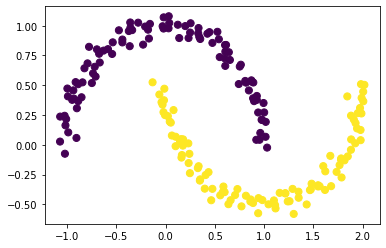

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y,
            s=50, cmap='viridis');

In [7]:
# Your code here

5. Use the following data, fit Gaussian mixture model from scratch

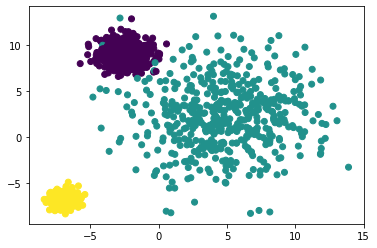

In [8]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=1500,
                             cluster_std=[1.0, 3.5, 0.5],
                            random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y)

The concept is fairly simple.  Indeed, it is very similar to K-Means, i.e., instead of using the mean to determine which point belongs to which cluster, it uses the probability of a gaussian distribution to determine whether each sample $x_i$ should belong to which clusters.  For example, sample $x_i$ probabilty with first cluster is 0.1 and second cluster is 0.5, then we will assign $x_i$ to second cluster.  

Of course, similar to K-means, we also have to update the cluster gaussian distribution.  The formula will be given below.

That's it!

Detailed steps are as follows:

**Initialization:**
1. Define k number of clusters (c)
2. For each cluster, randomly initialize parameters mean $\mu_c$, covariance $\Sigma_c$, and fraction per class $\pi_c$ 

**E-step:** 
1. For each $x_i$, calculate the probability $r_{ic}$ (shape: $n * k$) that $x_i$ belongs to cluster c using this equation:

$$ r_{ic} = \frac{\pi_cN(x_i \mid \mu_c, \Sigma_{c})}{\Sigma_{k=1}^{K} \pi_kN(x_i \mid \mu_k, \Sigma_k)}$$

where $N(x_i \mid \mu_c, \Sigma_c)$ is the multivariate Gaussian distribution, computed using:

$$N(x_i \mid \mu_c, \Sigma_c)= \frac{1}{(2\pi)^\frac{n}{2}\lvert{\Sigma_c}\rvert^\frac{1}{2}}\exp(-\frac{1}{2}(x_i-\mu_c)^T\Sigma_{c}^{-1}(x_i - \mu_c))$$

$r_ic$ basically gives us $$ \frac{\text{Probability of x_i belonging to class c}}{\text{Probability of x_i over all classes}} $$

**M-step:**
1. For each cluster c, recompute the gaussian distribution - namely update the $\mu_c$, covariance $\Sigma_c$, and fraction per class $\pi_c$.

Fraction of points belongs to cluster c:

$$ m_c = \Sigma{_i}r_{ic} $$

Fraction per class:

$$ \pi_c = \frac{m_c}{m}$$

Mean of each cluster c:

$$ \mu_c = \frac{1}{m_c}\Sigma{_i}r_{ic}x_i$$

Covariance of each cluster:

$$ \Sigma{_c} = \frac{1}{m_c}\Sigma{_i}r_{ic}(x_i - \mu_c)(x_i - \mu_c)^T $$

Iteratively repeat the E and M step until the log likelihood function converges.  Can be computed as follows:

$$ ln p(X \mid \pi, \mu, \Sigma) = \Sigma_{i=1}^{N} ln(\Sigma_{k=1}^{K}\pi_kN(x_i\mid\mu_k,\Sigma_k)) $$

**Coding considerations**

1.  To ease our programming efforts, we can use <code>scipy.stats.multivariate_normal</code> for generating gaussian distribution, and using its <code>.pdf()</code> function to compute the values we want of $N(x_i \mid \mu_c, \Sigma_c)$ and use <code>logpdf()</code> to define stopping criteria

2. Shape of $R$ which keeps probability of $x_i$ belonging to kth cluster is $(n * k)$, where n is <code>X.shape[0]</code> and k is <code>n_clusters</code> we want.  This fact will be helpful when initializing

3. Shape of $\Sigma$ or covariance of each cluster is simply $(m * m)$ where m is n_features or X.shape[1]. If we define 3 clusters, then we will have [$\Sigma_1$, $\Sigma_2$, $\Sigma_3$], each with shape $(m * m)$, thus whole thing is shape $ (k * m * m) $

4. Shape of $\pi$ is simply $(k, )$
    
5. Shape of $\mu$ is similarly $(m, k)$, defining mean for each feature for kth cluster

6. What to initialize can be tricky.  For R and $\pi$, you can fill with 1/k.  As for $\mu$, it is easiest to simply pick random points from the samples as initial means.  Last, for covariance ($\Sigma$), we can simply use the covariance of the X as initialization (i.e., <code>np.cov(X.T)</code>)

In [9]:
# Your code here